In [1]:
# Kütüphaneler ve veri setinin yüklenmesi / Loading libraries and dataset

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from keras.metrics import Accuracy

# Aynı değerleri elde edebilmek için seed değerini sabitliyoruz.
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
DATASET_PATH = "C:\\Users\\Dell\\Desktop\\Turkish speech command dataset\\"
data_dir = pathlib.Path(DATASET_PATH)

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000, # ses verilerin uzunluğu 1 saniye ve klipler 16 kHz olduğu için 16000 yazdık.
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 26484 files belonging to 14 classes.
Using 21188 files for training.
Using 5296 files for validation.

label names: ['ac' 'asagi' 'baslat' 'devam' 'dur' 'evet' 'geri' 'hayir' 'ileri' 'iptal'
 'kapa' 'sag' 'sol' 'yukari']


In [4]:
# Ses kiplerinin sahip olduğu boyutlarına bakıyoruz. (batch, samples, channels)
# The audio clips have a shape of (batch, samples, channels).

train_ds.element_spec 

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [5]:
#Bu veri seti tek bir kanal içerdiği için (mono olduğu için) tf.squeeze fonksiyonu ile kullanmadığımız axis'i atıyoruz.
#This dataset only contains single channel audio, so use the tf.squeeze function to drop the extra axis

def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [6]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [7]:
# validasyon setini modele uygulamadan önce modelin doğruluğunu ölçmek için validasyon ve test olarak 2 parçaya ayırıyoruz.
# Before applying the validation set to the model, we divide it into two parts as validation and test to measure the accuracy of the model.

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [8]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [9]:
# Birkaç tane verimize bi göz atalım
# Let's look at some of our data

label_names[[1,4,3,0]]

array(['asagi', 'dur', 'devam', 'ac'], dtype='<U6')

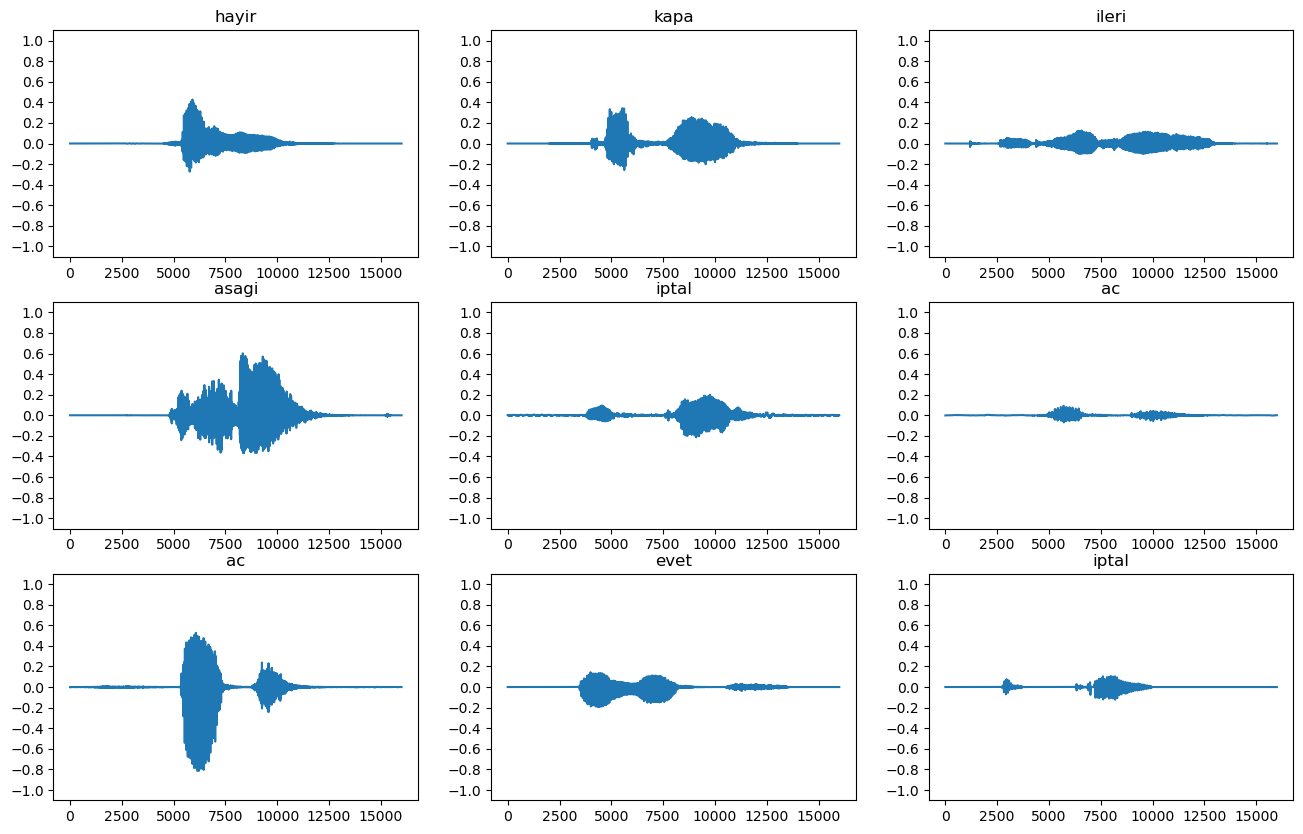

In [10]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [11]:
def get_spectrogram(waveform):
    # Ses dalgasını spectrograma dönüştürüyoruz.
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    # Mutla değerini alıyoruz.
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # CNN de kullanabilmek için boyutları ekliyoruz (batch_size, height, width, channels).
    # Add a `channels` dimension, so that the spectrogram can be used as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [12]:
for i in range(8):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: hayir
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: kapa
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: ileri
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: asagi
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: iptal
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: ac
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: ac
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: evet
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [13]:
# spectrogramları görüntüleyebilmek için bir fonksiyon tanımlıyoruz.
# we define a function for displaying a spectrogram
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Frekansları logaritmik ölçeğe dönüştürüyoruz ve transpoze ediyoruz, böylece zaman x ekseninde (sütunlar) gösteriyor.
    # Sıfırın logaritmasını almamak için bir epsilon ekliyoruz.
    # Convert the frequencies to log scale and transpose, so that the time is represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

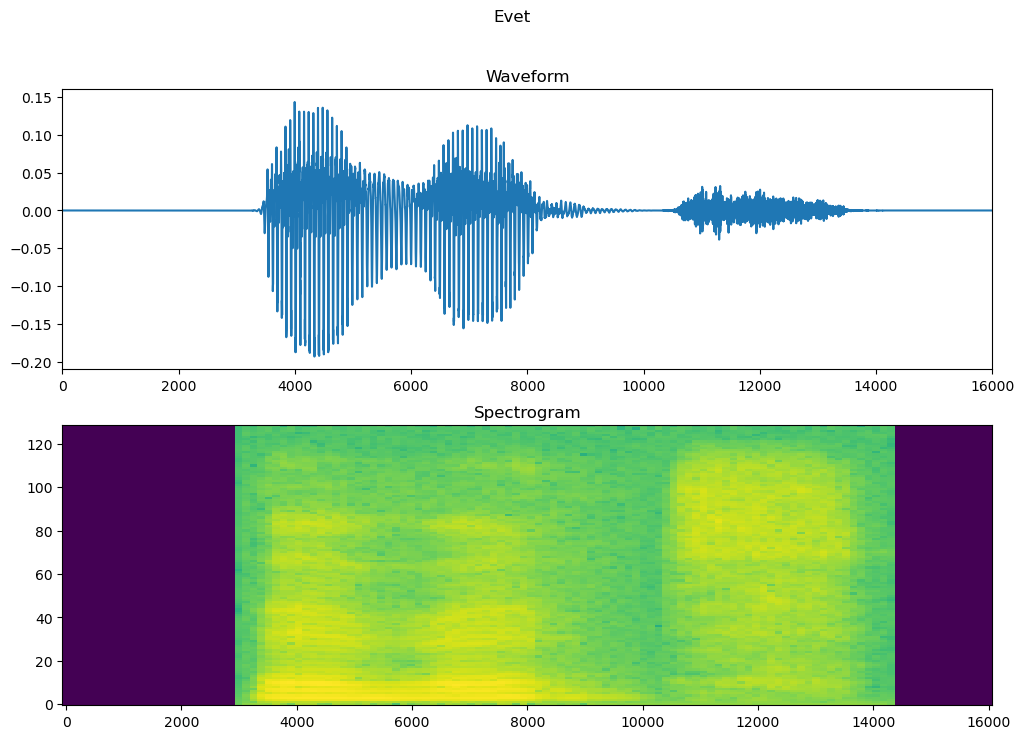

In [14]:
#Ses dalgasının zaman içindeki frekansını ve spectrogramı çizdiriyoruz.
#Plot the example's waveform over time and the corresponding spectrogram (frequencies over time).
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [15]:
# Ses veri seitimizden spectrogram veri setimizi oluşturalım
# Create spectrogram datasets from the audio datasets:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [17]:
#Veri setinin farklı örnekleri için spektrogramları inceleyelim
#Examine the spectrograms for different examples of the dataset
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

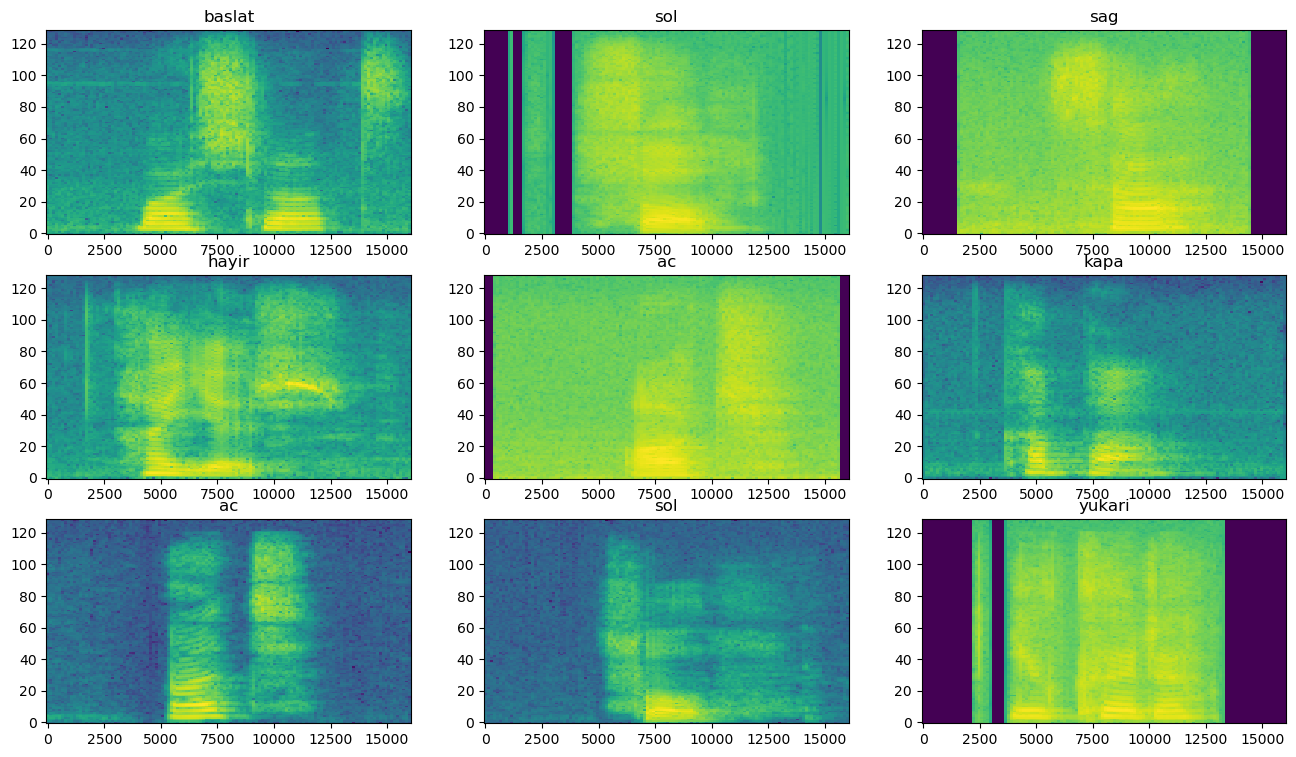

In [18]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [19]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [20]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

norm_layer = layers.Normalization()

norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           

In [21]:
# optimizer olarak Adam, loss fonksiyonu olarak Sparse Categorical Crossentropy tanımlıyoruz.

# Configure the Keras model with the Adam optimizer and the cross-entropy loss:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [22]:
EPOCHS = 15
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/15
332/332 [==============================] - 44s 129ms/step - loss: 0.8952 - accuracy: 0.7369 - val_loss: 0.3429 - val_accuracy: 0.8895
Epoch 2/15
332/332 [==============================] - 18s 55ms/step - loss: 0.4103 - accuracy: 0.8775 - val_loss: 0.2526 - val_accuracy: 0.9257
Epoch 3/15
332/332 [==============================] - 14s 43ms/step - loss: 0.3074 - accuracy: 0.9069 - val_loss: 0.1982 - val_accuracy: 0.9417
Epoch 4/15
332/332 [==============================] - 15s 46ms/step - loss: 0.2482 - accuracy: 0.9268 - val_loss: 0.1987 - val_accuracy: 0.9447
Epoch 5/15
332/332 [==============================] - 14s 44ms/step - loss: 0.2151 - accuracy: 0.9352 - val_loss: 0.1725 - val_accuracy: 0.9535
Epoch 6/15
332/332 [==============================] - 15s 46ms/step - loss: 0.1776 - accuracy: 0.9455 - val_loss: 0.1661 - val_accuracy: 0.9512
Epoch 7/15
332/332 [==============================] - 16s 47ms/step - loss: 0.1715 - accuracy: 0.9480 - val_loss: 0.1535 - val_accuracy

Text(0, 0.5, 'Accuracy [%]')

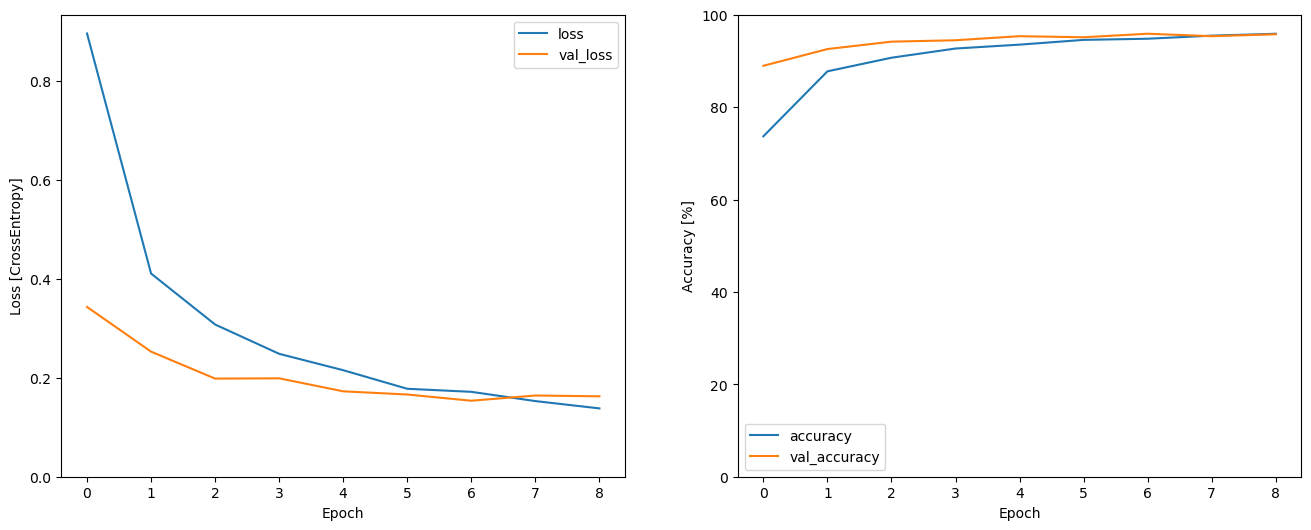

In [23]:
# Accuracy ve loss grafiklerini çizerek eğitim sürecini gözlemliyelim
# Let's plot the training and validation loss curves to check how your model has improved during training
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [24]:
model.evaluate(test_spectrogram_ds, return_dict=True)

42/42 [==============================] - 1s 29ms/step - loss: 0.1329 - accuracy: 0.9641


{'loss': 0.1328788846731186, 'accuracy': 0.9640718698501587}

In [25]:
y_pred = model.predict(test_spectrogram_ds)

42/42 [==============================] - 1s 11ms/step


In [26]:
y_pred = tf.argmax(y_pred, axis=1)

In [27]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

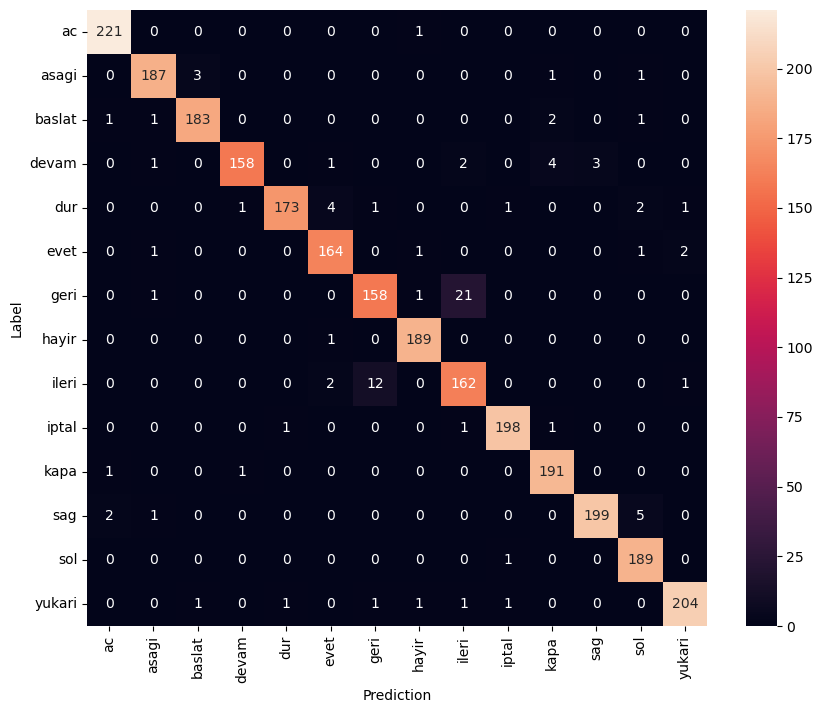

<tf.Tensor: shape=(), dtype=float32, numpy=0.96407187>

In [28]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()
m = Accuracy()
m.update_state(y_pred, y_true)
m.result()

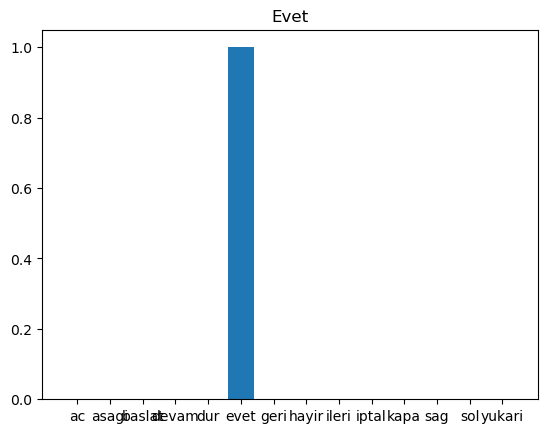

In [29]:
x = "C:\\Users\\Dell\\Desktop\\Turkish speech command dataset\\evet\\evet_AEMH_JLCYNAE.wav"
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Evet')
plt.show()

display.display(display.Audio(waveform, rate=16000))